In [144]:
import os
import yaml
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [156]:
# Load the required data #
outputPath = '/home/ucl/cp3/sdonerta/bamboodev/WWGG/10_11_Skim_Slurm/'
skimFile = os.path.join(outputPath,'results','Skim.parquet')
yamlFile = os.path.join(outputPath,'plots.yml')

# Load dataframe from parquet #
df = pd.read_parquet(skimFile)

# Load samples + plots data from yaml file #
with open(yamlFile,'r') as handle:
    config = yaml.load(handle)


/nfs/scratch/fynu/fbury/ipykernel_3442096/3780820245.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(handle)


In [157]:
# Cut negative event weights #
df = df[df['weight']>0]

# Cut QCD events #
df = df[~df.process.str.contains("QCD")]

In [158]:
# Set labels #
df["label"] = 0
for process in pd.unique(df['process']):
    if process not in config['files']:
        raise RuntimeError(f'Process {process} not found in yaml config file')
    if config['files'][process]['type'] == 'signal':
        df.loc[df['process']==process, ['label']] = 1

In [159]:
print(df)

       weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1    0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2    0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
3    0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   
4    0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   
..        ...       ...       ...        ...         ...       ...       ...   
687  0.784736  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   
688  0.784736  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   
689  0.784736  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   
690  0.784736  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   
691  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   

     E_mGG_ph2  pT_mGG_ph2  Electron_E 

In [160]:
# Produce physical event weight #
df['event_weight'] = pd.Series(np.zeros(df.shape[0]))
lumi = config['configuration']['luminosity']['HL-LHC']
for process in pd.unique(df['process']):
    print (f'Looking at process {process}')
    if 'cross-section' in config['files'][process].keys() and config['files'][process]['type'] != 'signal':
        cross_section = config["files"][process]["cross-section"]
    else:
        cross_section = 1.
        # For signal, we assume unit cross section (otherwise significance can be too unstable)
    if 'branching-ratio' in config['files'][process].keys():
        BR = config["files"][process]["branching-ratio"]
    else:
        BR = 1
    if 'generated-events' in config['files'][process].keys():
        
        generated_events = config["files"][process]["generated-events"]
    else:
        raise RuntimeError('Process {process} is missing `generated-events` entry, should not happen')
        
    print (f'... cross-section = {cross_section}')
    print (f'... branching-ratio = {BR}')
    print (f'... generated-events = {generated_events}')
    factor = lumi * cross_section * BR / generated_events
    # We don't really care about luminosity because the scale of the weights do not matter, and you have a single lumi
    print (f'   -> Total factor = {factor}')
    # Apply to the new event_weight columns #
    df.loc[df["process"]==process,'event_weight'] = df[df["process"]==process]['weight'] * factor
    print (f'   Sum of weights = {df[df["process"]==process]["weight"].sum()} -> {df[df["process"]==process]["event_weight"].sum()}')


if (df['event_weight'] < 0).sum() > 0:
    raise RuntimeError(f"There are {(df['event_weight'] < 0).sum()} events with negative event weight, this should not happen")

Looking at process GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
... cross-section = 1.0
... branching-ratio = 1
... generated-events = 65241.65374448523
   -> Total factor = 45.982893256343694
   Sum of weights = 2.345959186553955 -> 107.87401476898096
Looking at process GluGluHToGG_M125_TuneCP5_14TeV-amcatnloFXFX-pythia8_200PU.root
... cross-section = 0.114798
... branching-ratio = 1
... generated-events = 55033679.55371094
   -> Total factor = 0.00625787704534427
   Sum of weights = 414.35626220703125 -> 2.5929905269294977
Looking at process VBFHToGG_M125_TuneCP5_14TeV-amcatnlo-pythia8_200PU.root
... cross-section = 0.00951216
... branching-ratio = 1
... generated-events = 7894933.640413284
   -> Total factor = 0.003614530697753423
   Sum of weights = 132.13275146484375 -> 0.47759788983967155
Looking at process ttHJetToGG_M125_TuneCP5_14TeV-amcatnloFXFX-madspin-pythia8_200PU.root
... cross-section = 0.001393764
... branching-ratio = 1
... generated-events = 

In [161]:
# Compute learning weight #


df['training_weight'] = df['event_weight']
df.loc[df['label']==1,'training_weight'] *= df.shape[0]/2 / (df[df['label']==1]['event_weight']).sum()
df.loc[df['label']==0,'training_weight'] *= df.shape[0]/2 / (df[df['label']==0]['event_weight']).sum()



In [162]:
import utils
importlib.reload(utils) # Reload in case file has changed
print ('Using event weight')
utils.checkBatches(df,weight_column='event_weight')
print ('Using training weight')
utils.checkBatches(df,weight_column='training_weight')

Using event weight
On average, per batch the total learning weight is
	... signal     :     0.042285782 [36.048 events]
	... background : 16623.718716178 [91.952 events]
Using training weight
On average, per batch the total learning weight is
	... signal     :    63.512713521 [35.383 events]
	... background :    68.015615676 [92.617 events]


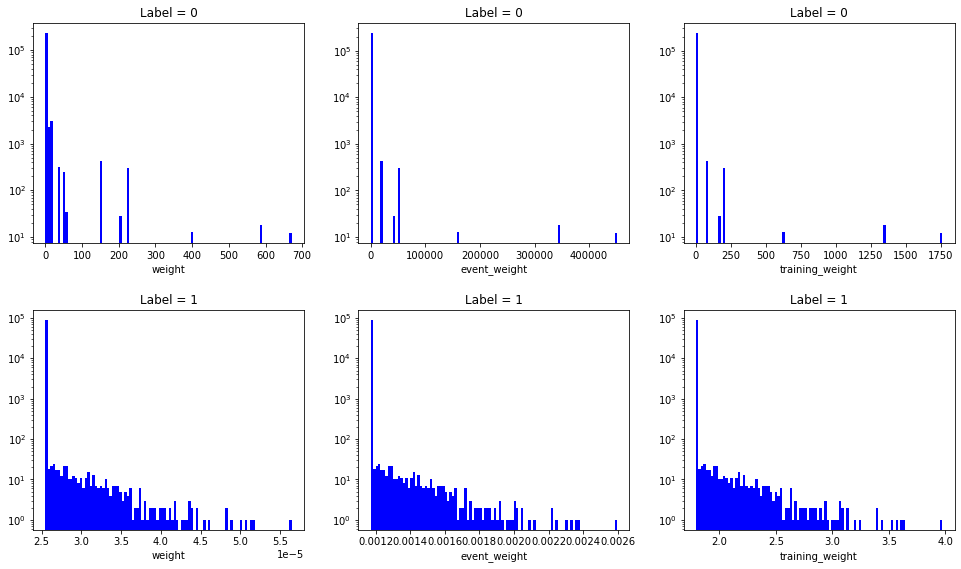

In [169]:
fig,axs = plt.subplots(figsize=(16,8),nrows=2,ncols=3)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.3)
for irow,label in enumerate([0,1]):
    for icol,column in enumerate(['weight','event_weight','training_weight']):
        axs[irow,icol].hist(df[df['label']==label][column],bins=100,color='b')
        axs[irow,icol].set_title(f"Label = {label}")
        axs[irow,icol].set_xlabel(column)
        axs[irow,icol].set_yscale('log')
        #axs[irow,icol].legend(loc='upper center')
fig.savefig("event_weights_A.pdf", dpi = 300)


In [170]:
input_vars=["Eta_ph1",
            "Phi_ph1",
            "E_mGG_ph1",
            "pT_mGG_ph1",
            "Eta_ph2",
            "Phi_ph2",
            "E_mGG_ph2",
            "pT_mGG_ph2",
            "Electron_E",
            "Electron_pT",
            "Electron_Eta",
            "Electron_Phi",
            "Muon_E",
            "Muon_pT",
            "Muon_Eta",
            "Muon_Phi",
            "nJets",
            "E_jet1",
            "pT_jet1",
            "Eta_jet1",
            "Phi_jet1",
            "E_jet2",
            "pT_jet2",
            "Eta_jet2",
            "Phi_jet2",
            "InvM_jet",
            "InvM_jet2",
            "met"]

In [171]:
print(df[input_vars])

      Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  E_mGG_ph2  \
0    1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   2.097534   
1   -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   2.815203   
2    0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   0.430226   
3    1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   6.344330   
4   -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   0.565238   
..        ...       ...        ...         ...       ...       ...        ...   
687  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   0.569781   
688  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   0.728969   
689  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   1.145351   
690  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   1.119852   
691 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   0.297948   

     pT_mGG_ph2  Electron_E

In [191]:
train_df,test_df = train_test_split(df,test_size=0.3)
train_df,val_df  = train_test_split(train_df,test_size=0.3)
print (f'Training set   = {train_df.shape[0]}')
print (f'Validation set = {val_df.shape[0]}')
print (f'Testing set    = {test_df.shape[0]}')
print (f'Total set      = {df.shape[0]}')

Training set   = 161799
Validation set = 69343
Testing set    = 99062
Total set      = 330204


In [231]:
parameters = {
    'epochs'                : 200,
    'lr'                    : 0.001,
    'batch_size'            : 256,
    'n_layers'              : 5,
    'n_neurons'             : 128,
    'hidden_activation'     : 'selu',
    'output_activation'     : 'sigmoid',
    'l2'                    : 1e-6,
    'dropout'               : 0.2,
    'batch_norm'            : False,
}
# L2 is an additional term in the loss function : l2 x ||W||**2 where ||W|| is the sum of all the DNN weights 
#    inside the neurons
# -> when overfitting the weights take large values, this tells the optimizer the trade off between performances
#    and generalization
# Dropout is a frequency of killing neurons at each batch (no backprogation for them)
# -> used generally when overfitting is detected, to avoid that the DNN learns too much
# Batch normalization is a layer that normalizes the output of each neuron (see documentation)
# -> usually helps that the gradient does not go too far and backprogation is always smooth (supposedly)

In [232]:
# Input layer #
inputs = keras.Input(shape=(len(input_vars),), name="particles")

# Preprocessing layer
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(mean     = train_df[input_vars].mean(axis=0),
                                         variance = train_df[input_vars].var(axis=0),
                                         name     = 'Normalization')(inputs)
    # this layer does the preprocessing (x-mu)/std for each input
# Dense (hidden) layers #
x = normalizer
for i in range(parameters['n_layers']):
    x = layers.Dense(units                = parameters['n_neurons'], 
                     activation           = parameters['hidden_activation'], 
                     activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                     name                 = f"dense_{i}")(x)
    if parameters['batch_norm']:
        x = layers.BatchNormalization()(x)
    if parameters['dropout'] > 0.:
        x = layers.Dropout(parameters['dropout'])(x)
# Output layer #
outputs = layers.Dense(units                = 1, 
                       activation           = parameters['output_activation'],
                       activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                       name                 = "predictions")(x)

# Registering the model #
model = keras.Model(inputs=inputs, outputs=outputs)

In [233]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Adam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
particles (InputLayer)       [(None, 28)]              0         
_________________________________________________________________
Normalization (Normalization (None, 28)                57        
_________________________________________________________________
dense_0 (Dense)              (None, 128)               3712      
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               165

/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [234]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.001, 
                               patience = 51,
                               verbose=1,
                               mode='min')
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.5,
                                   min_delta = 0.001, 
                                   patience = 10,
                                   min_lr = 1e-8,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
import History 
importlib.reload(History)
loss_history = History.LossHistory()

In [235]:
history = model.fit(
    train_df[input_vars],
    train_df['label'],
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=train_df['training_weight'],
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(val_df[input_vars],val_df['label'],val_df['training_weight']),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)


Epoch 1/200
633/633 - 11s - loss: 0.7439 - binary_accuracy: 0.4991 - auc_16: 0.5961 - precision_16: 0.3220 - recall_16: 0.7211 - val_loss: 0.5302 - val_binary_accuracy: 0.5010 - val_auc_16: 0.6305 - val_precision_16: 0.3339 - val_recall_16: 0.7872
Epoch 2/200
633/633 - 5s - loss: 0.7215 - binary_accuracy: 0.4635 - auc_16: 0.5697 - precision_16: 0.3074 - recall_16: 0.7387 - val_loss: 0.6697 - val_binary_accuracy: 0.4213 - val_auc_16: 0.5954 - val_precision_16: 0.3039 - val_recall_16: 0.8280
Epoch 3/200
633/633 - 5s - loss: 0.5336 - binary_accuracy: 0.4550 - auc_16: 0.5851 - precision_16: 0.3078 - recall_16: 0.7654 - val_loss: 0.4494 - val_binary_accuracy: 0.4301 - val_auc_16: 0.6052 - val_precision_16: 0.3086 - val_recall_16: 0.8357
Epoch 4/200
633/633 - 5s - loss: 0.4959 - binary_accuracy: 0.4472 - auc_16: 0.5774 - precision_16: 0.3067 - recall_16: 0.7801 - val_loss: 0.5023 - val_binary_accuracy: 0.4256 - val_auc_16: 0.4851 - val_precision_16: 0.2810 - val_recall_16: 0.6756
Epoch 5/200

Epoch 34/200
633/633 - 5s - loss: 0.2662 - binary_accuracy: 0.4092 - auc_16: 0.6195 - precision_16: 0.3027 - recall_16: 0.8592 - val_loss: 0.4175 - val_binary_accuracy: 0.4012 - val_auc_16: 0.6293 - val_precision_16: 0.3028 - val_recall_16: 0.8750

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 35/200
633/633 - 5s - loss: 0.2458 - binary_accuracy: 0.4027 - auc_16: 0.6275 - precision_16: 0.3020 - recall_16: 0.8724 - val_loss: 0.4481 - val_binary_accuracy: 0.3992 - val_auc_16: 0.6398 - val_precision_16: 0.3029 - val_recall_16: 0.8812
Epoch 36/200
633/633 - 5s - loss: 0.2381 - binary_accuracy: 0.4008 - auc_16: 0.6331 - precision_16: 0.3017 - recall_16: 0.8751 - val_loss: 0.4526 - val_binary_accuracy: 0.4047 - val_auc_16: 0.6561 - val_precision_16: 0.3055 - val_recall_16: 0.8854
Epoch 37/200
633/633 - 5s - loss: 0.2331 - binary_accuracy: 0.4064 - auc_16: 0.6415 - precision_16: 0.3046 - recall_16: 0.8811 - val_loss: 0.4159 - val_binary_accuracy: 0.4245

Epoch 00065: early stopping


Curves saved as loss.png


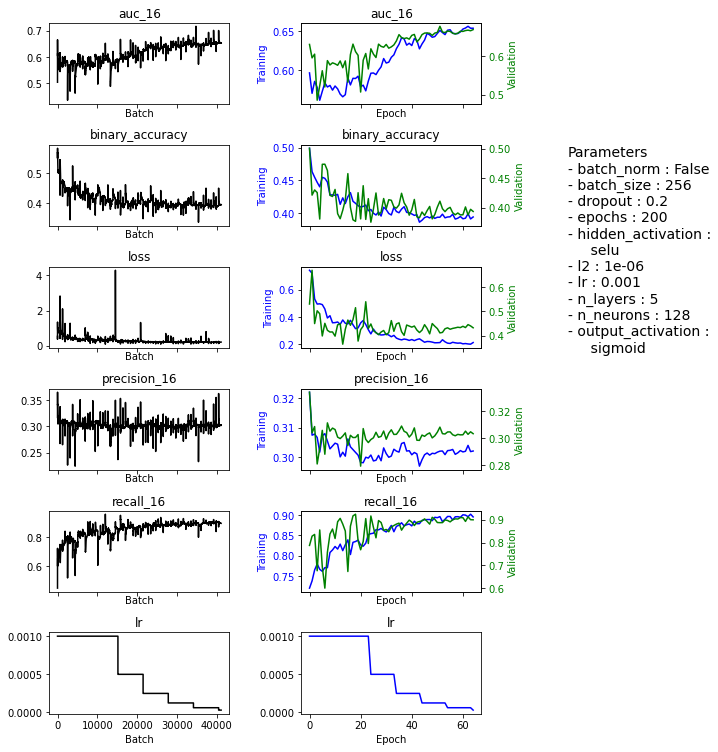

In [236]:
History.PlotHistory(loss_history,params=parameters,outputName='loss.png')
# Params is a dict of parameters with name and values
# used for plotting


In [237]:
# Produce output on the test set as new column #
output = model.predict(test_df[input_vars],batch_size=5000)
    # Here the batch_size arg is independent of the learning
    # Default is 32, but it can become slow, by using large value it will just compute more values in parallel
    # (more or less parallel, we are not using a GPU)
if 'output' in test_df.columns:
    # If already output, need to remove to add again
    # avoid issues in case you run this cell multiple times
    del test_df['output']
test_df = pd.concat((test_df,pd.DataFrame(output,columns=['output'],index=test_df.index)),axis=1)
# We add the output as a column, a bit messy, different ways, here I use a concatenation

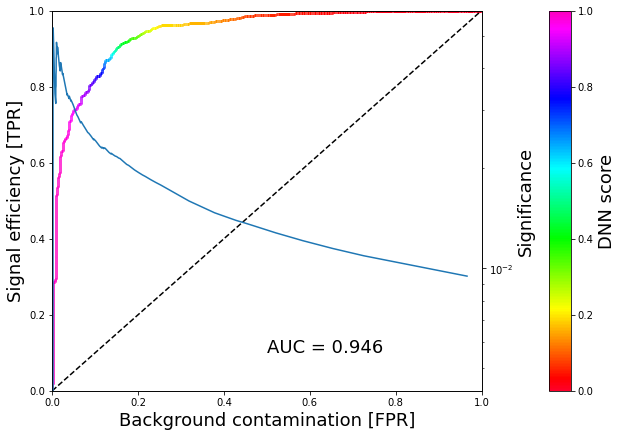

Saved ROC as roc_training.pdf
Best WP based on significance = 0.99891


In [238]:
import roc
importlib.reload(roc) # Reload in case file has changed
roc.rocAndSig(test_df['label'],test_df['output'],w_roc=test_df['training_weight'],w_sig=test_df['event_weight'],outputName='roc_training.pdf')


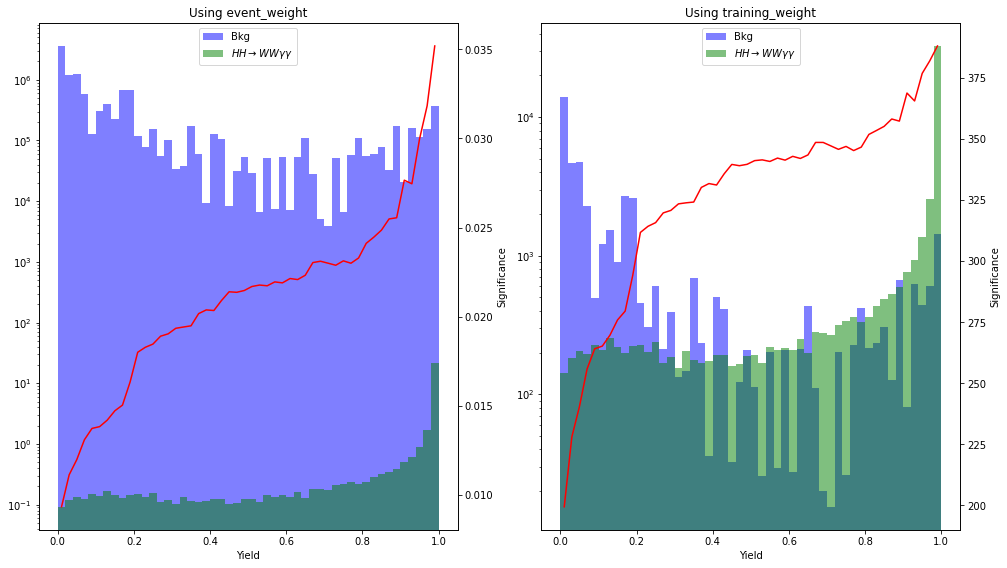

In [239]:
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.3)

sig_df = test_df[test_df['label']==1]
bkg_df = test_df[test_df['label']==0]

# Manual binning so we can compute significane #
bins = np.linspace(0,1,51)
centers = (bins[1:]+bins[:-1])/2
widths = np.diff(bins)


def get_bin_content(y,w):
    digitized = np.digitize(y,bins)
    return np.array([w[digitized==i].sum() for i in range(1, len(bins))])

for icol,weight in enumerate(['event_weight','training_weight']):
    # Fill the bins myself #
    b = get_bin_content(bkg_df['output'],bkg_df[weight])
    s = get_bin_content(sig_df['output'],sig_df[weight])
    cumsum_b = np.cumsum(b[::-1])[::-1]
    cumsum_s = np.cumsum(s[::-1])[::-1]
    # Need to integrate all the bins right of the DNN cut to get significance
    z = np.nan_to_num(np.sqrt(2*((cumsum_s+cumsum_b)*np.log(1+cumsum_s/cumsum_b)-cumsum_s)))
    axs[icol].bar(x=centers,height=b,width=widths,alpha=0.5,color='b',label='Bkg')
    axs[icol].bar(x=centers,height=s,width=widths,alpha=0.5,color='g',label=r'$HH \rightarrow WW \gamma \gamma$')
    ax2=axs[icol].twinx()   
    ax2.plot(centers,z,color='r',label='Significance')
    #ax2.set_yscale("log")
    #ax2.set_ylim([0,z.max()*1.1])
    ax2.set_ylabel('Significance')

    axs[icol].set_title(f"Using {weight}")
    axs[icol].set_xlabel('DNN output')
    axs[icol].set_xlabel('Yield')
    axs[icol].set_yscale('log')
    axs[icol].legend(loc='upper center')
fig.savefig("prediction.pdf", dpi = 300)



In [230]:
# evaluate the model
scores = model.evaluate(test_df[input_vars], 
                        test_df['label'], 
                        sample_weight = test_df['training_weight'], 
                        batch_size = 5000,
                        verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

20/20 - 3s - loss: 0.7632 - binary_accuracy: 0.4983 - auc_15: 0.4681 - precision_15: 0.2621 - recall_15: 0.4452
binary_accuracy: 49.83%


In [ ]:
# save model and architecture to single file
model.save("model_dnn_13_12_noQCD")
print("Saved model to disk")